# INFO 602 Final Project - InfoSec Open Source Intelligence (OSINT) Categorization
Michael Poff

In [409]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import string
import numpy as np
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer


_ = nltk.download('averaged_perceptron_tagger', quiet=True)
_ = nltk.download('wordnet', quiet=True)

## Data

In [410]:
data = pd.read_excel('./data/article_data.xlsx')
display (Markdown(f"The dataset contains {len(data)} data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:"))

The dataset contains 310 data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:

-   Title: The title of the article.
-   Content: The article contents.
-   Category: A manually labeled category label, chosen from one of nine options (listed below).
-   Zero-Shot Category: A label applied by the [HuggingFace zero-shot classification transformer](https://huggingface.co/tasks/zero-shot-classification) using the same set of nine options.
-   Zero-Shot Match: Indicates whether the zero-shot classification corresponds with the manual category assignment, expressed as TRUE or FALSE.

**Categories:**
-   Vulnerability Reports: Specific vulnerabilities found in software or hardware.
-   Security Updates and Patches: Latest releases of security patches and updates.
-   Emerging Threats and Attack Techniques: New cyber threats and attack methods.
-   Regulatory Changes and Compliance: Updates to cybersecurity laws and regulations.
-   Data Breaches and Security Incidents: Reports and analyses of recent data breaches or security incidents.
-   News and Industry Updates: General security news.
-   Marketing: Content primarily meant to highlight, advertise, or market a security product.

**Sources:**
-   [The Hacker News](https://thehackernews.com/)
-   [Bleeping Computer](https://www.bleepingcomputer.com/)
-   [Dark Reading](https://www.darkreading.com/)
-   [CISA Advisories](https://www.cisa.gov/news-events/cybersecurity-advisories)
-   [The Register - Security](https://www.theregister.com/security/)

The title and article data were scraped using the Python library [Trafilatura](https://github.com/adbar/trafilatura) which does a good job of scraping content and metadata from article web pages, however some results are skewed. Rather than manually refine the data, the model should learn to ignore this extraneous text.

## Preprocessing
This section tokenizes the contents of each article (breaks the content down into a series of words) and performs a set of clean-up tasks known as preprocessing.

*Thanks to Afham Fardeen for his [guide](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) to performing text preprocessing.*

In [411]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_lg')

# Add custom stop words
custom_stopwords = {'said', 'say','use','include'}
for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word)

# Add an ID column to the data for better tracking
data['ID'] = range(0, len(data))

# Convert the data in the content column to lowercase
data['content'] = data['content'].str.lower()

# Perform sentence tokenization
def sentence_tokenize(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences
data['sentences'] = data['content'].apply(sentence_tokenize)

# Handle abbreviations in the data that align with stopwords
def replace_abbreviations(text):
    replacements = {'u.s.': 'usa', 'u.s': 'usa'}
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text
data['content'] = data['content'].apply(replace_abbreviations)

# Remove urls from the data
def remove_urls(text):
    # Regex pattern for matching URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)

# Apply the URL removal function before processing the text with spaCy
data['content'] = data['content'].apply(remove_urls)

def remove_punctuation_from_text(text):
    # Create a translation table where each punctuation mark is mapped to a space
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    # Use the translation table to replace punctuation with spaces in the text
    return text.translate(table)

# Assuming 'data' is your DataFrame and 'content' is the column with text to process
data['content'] = data['content'].apply(remove_punctuation_from_text)

# Function to process text with spaCy, incorporating tokenization, stop word removal, lemmatization, and non-ASCII removal
def process_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_ascii and not token.is_punct:
            if token.lemma_.lower() == "datum": # some instances of the word data were being lematized to datum and others were not, normalizing on the word data rather than datum.
                token.lemma_ = "data"
                
            tokens.append(token.lemma_.lower())
    return tokens

data['words'] = data['content'].apply(process_text)

# Remove tokens that are a single character long
def remove_short_tokens(text):
    result = []
    for word in text:
        if len(word) > 1:
            result.append(word)
    return result
data['words'] = data['words'].apply(remove_short_tokens)

data['joined_words'] = data['words'].apply(lambda x: ' '.join(x))


## Exploratory Data Analysis

### Data Preview
First, a quick look at a row of data. This is limited to a single row because the contents are quite large.

In [412]:
data.head(1).style.set_properties(**{'background-color': 'black', 
                                   'color': 'white', 
                                   'border-color': 'gray'})

,title,content,category,zero-shot category,zero-shot match,ID,sentences,words,joined_words
0,CISA Warns of Active Exploitation Apple iOS and macOS Vulnerability,the usa cybersecurity and infrastructure security agency cisa on wednesday added a high severity flaw impacting ios ipados macos tvos and watchos to its known exploited vulnerabilities kev catalog based on evidence of active exploitation the vulnerability tracked as cve 2022 48618 cvss score 7 8 concerns a bug in the kernel component an attacker with arbitrary read and write capability may be able to bypass pointer authentication apple said in an advisory adding the issue may have been exploited against versions of ios released before ios 15 7 1 the iphone maker said the problem was addressed with improved checks it s currently not known how the vulnerability is being weaponized in real world attacks interestingly patches for the flaw were released on december 13 2022 with the release of ios 16 2 ipados 16 2 macos ventura 13 1 tvos 16 2 and watchos 9 2 although it was only publicly disclosed more than a year later on january 9 2024 it s worth noting that apple did resolve a similar flaw in the kernel cve 2022 32844 cvss score 6 3 in ios 15 6 and ipados 15 6 which was shipped on july 20 2022 it s not immediately clear if the two vulnerabilities are related an app with arbitrary kernel read and write capability may be able to bypass pointer authentication the company said at the time a logic issue was addressed with improved state management in light of the active exploitation of cve 2022 48618 cisa is recommending that federal civilian executive branch fceb agencies apply the fixes by february 21 2024 the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine cve 2024 23222 cvss score 8 8 to include its apple vision pro headset the fix is available in visionos 1 0 2,vulnerability reports,security updates and patches,False,0,"['the u.s. cybersecurity and infrastructure security agency (cisa) on wednesday added a high-severity flaw impacting ios, ipados, macos, tvos, and watchos to its known exploited vulnerabilities (kev) catalog, based on evidence of active exploitation.the vulnerability, tracked as cve-2022-48618 (cvss score: 7.8), concerns a bug in the kernel component.', '""an attacker with arbitrary read and write capability may be able to bypass pointer authentication,"" apple said in an advisory, adding the issue ""may have been exploited against versions of ios released before ios 15.7.1.""the iphone maker said the problem was addressed with improved checks.', ""it's currently not known how the vulnerability is being weaponized in real-world attacks.interestingly, patches for the flaw were released on december 13, 2022, with the release of ios 16.2, ipados 16.2, macos ventura 13.1, tvos 16.2, and watchos 9.2, although it was only publicly disclosed more than a year later on january 9, 2024.it's worth noting that apple did resolve a similar flaw in the kernel (cve-2022-32844, cvss score: 6.3) in ios 15.6 and ipados 15.6, which was shipped on july 20, 2022."", ""it's not immediately clear if the two vulnerabilities are related."", '""an app with arbitrary kernel read and write capability may be able to bypass pointer authentication,"" the company said at the time.', '""a logic issue was addressed with improved state management.', '""in light of the active exploitation of cve-2022-48618, cisa is recommending that federal civilian executive branch (fceb) agencies apply the fixes by february 21, 2024.the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine (cve-2024-23222, cvss score: 8.8) to include its apple vision pro headset.', 'the fix is available in visionos 1.0.2.']","['usa', 'cybersecurity', 'infrastructure', 'security', 'agency', 'cisa', 'wednesday', 'add', 'high', 'severity', 'flaw', 'impact', 'ios', 'ipados', 'macos', 'tvo', 'watc

### Categories
This is a simple count of how many articles there are per category.

In [413]:
data['category'].value_counts().reset_index()

,category,count
0,news and industry updates,138
1,emerging threats and attack techniques,55
2,vulnerability reports,38
3,data breaches and security incidents,35
4,marketing,22
5,security updates and patches,16
6,regulatory changes and compliance,6


### Zero-Shot vs. Manual Classification
This section demonstrates the effectiveness of zero-shot classification versus manual classification.


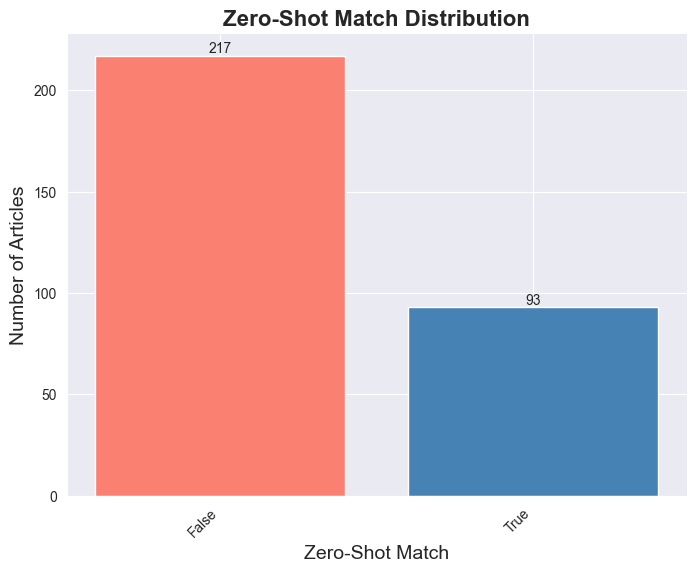

This plot demonstrates that zero-shot classification correctly classifies articles 30.0% of the time. This is a good benchmark for our model to compare against a deep neural network with a generalized task.

In [414]:
data['zero-shot match'] = data['zero-shot match'].astype(str)
grouped_data = data.groupby('zero-shot match').size().reset_index(name='n')

grouped_data.head(2)

colors = ['steelblue' if x == 'True' else 'salmon' for x in grouped_data['zero-shot match']]

# Creating the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(grouped_data['zero-shot match'], grouped_data['n'], color=colors)

# Adding text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Customizing the plot
plt.title('Zero-Shot Match Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Zero-Shot Match', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()

# Show plot
plt.show()


true_count = grouped_data.loc[grouped_data['zero-shot match'] == 'True', 'n'].item()
display(Markdown(f"This plot demonstrates that zero-shot classification correctly classifies articles {(true_count/len(data))*100}% of the time. This is a good benchmark for our model to compare against a deep neural network with a generalized task."
))

### Word Clouds
These word clouds distill the core themes across different cybersecurity categories, highlighting key terms. They offer a quick visual summary of the most discussed topics in the field.

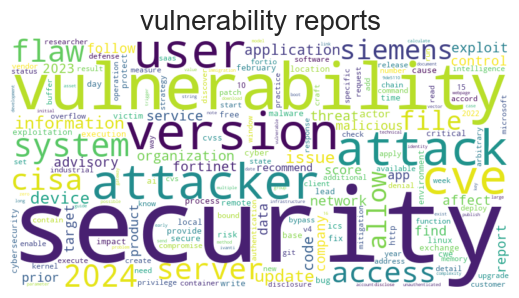

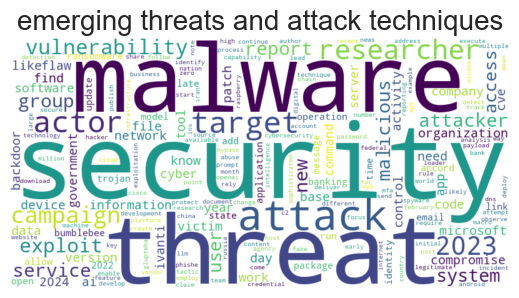

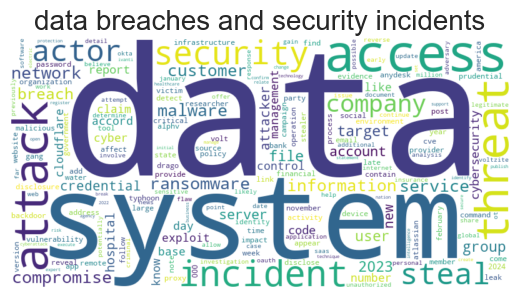

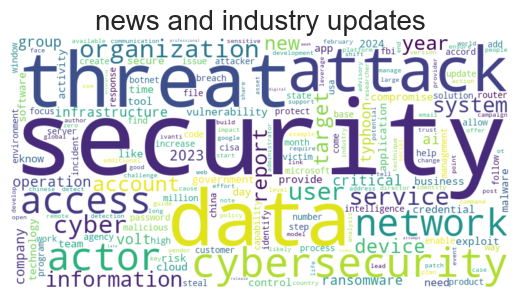

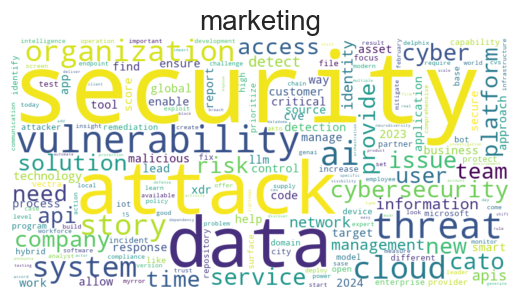

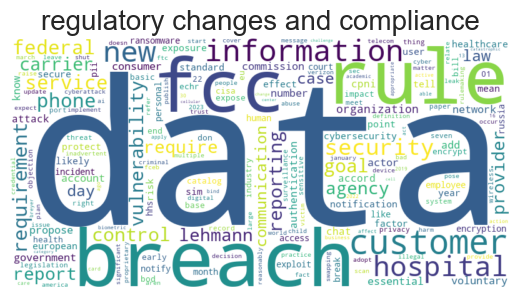

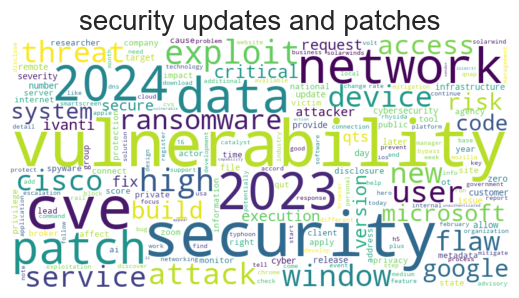

In [415]:
# Expand the list of words into a new row for each word
data_clean = data.explode('words').rename(columns={'words': 'word'})
data_clean = data_clean[data_clean['word'] != ""]  # Remove empty words

# Calculate word frequencies by category
word_frequencies_by_category = data_clean.groupby(['category', 'word']).size().reset_index(name='n')

# Iterate through each unique category to generate word clouds
for category in data_clean['category'].unique():
    # Filter data for the current category
    cat_data = word_frequencies_by_category[word_frequencies_by_category['category'] == category]
    
    # Generate a word cloud
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(dict(zip(cat_data['word'], cat_data['n'])))
    
    # Plotting the WordCloud                    
    plt.figure(figsize = (5, 2.5), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    
    plt.title(category, fontsize=20)
    plt.show()

## Fitting Models

### Bag of Words
Adapted from examples contained in the [scikit-learn user documentation](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py)

The [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) is a model of text which uses a representation of text that is based on an unordered collection (or "bag") of words.

This exercise will train and test eight different models and evaluate their effectiveness at properly classifying articles. Articles in this example are vectorized using TF-IDF.

The models being tested are:
   *  Logistic Regression
   *  Ridge Classification
   *  K Nearest Neighbor
   *  Random Forest
   *  Linear Support Vector Classification (SVC)
   *  Log Loss Stochastic Gradient Descent (SGD)
   *  Nearest Centroid a.k.a. Rocchio Classifier
   *  Complement Nayive Bayes Classifier

The first step is to split and vectorize the data.

In [416]:
# Split the data into test and training datasets
X_train, X_test, y_train, y_test = train_test_split(
    data['joined_words'], 
    data['category'], 
    test_size=0.2, 
    random_state=42, 
    stratify=data['category']
)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(
    sublinear_tf=True, 
    max_df=0.5,
    min_df=5, 
    stop_words="english"
    )

# Fit on and transform the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the test data
X_test = vectorizer.transform(X_test)



Now create a benchmark function to fit and test the effectiveness of each model, then run each model through the benchmark. 

In [417]:
# Helper function to benchmark models 
def benchmark(clf, custom_name=False):
    name = custom_name if custom_name else clf.__class__.__name__
    display(Markdown(f"___\n**{name}**"))    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,pred)*100
    precision = precision_score(y_test,pred,average='macro', zero_division=0)*100
    recall = recall_score(y_test,pred,average='macro') * 100
    display(Markdown(f"<p>Accuracy: {accuracy:.2f}%</p>"
                     f"<p>Precision: {precision:.2f}</p>"
                     f"<p>Recall: {recall:.2f}</p>")) 

# Benchmark the eight models
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "Log-Loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "Nearest Centroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement Naive Bayes"),
):
    benchmark(clf,name)

___
**Logistic Regression**

<p>Accuracy: 56.45%</p><p>Precision: 22.95</p><p>Recall: 26.41</p>

___
**Ridge Classifier**

<p>Accuracy: 53.23%</p><p>Precision: 22.91</p><p>Recall: 25.39</p>

___
**kNN**

<p>Accuracy: 45.16%</p><p>Precision: 6.45</p><p>Recall: 14.29</p>

___
**Random Forest**

<p>Accuracy: 51.61%</p><p>Precision: 25.24</p><p>Recall: 21.24</p>

___
**Linear SVC**

<p>Accuracy: 50.00%</p><p>Precision: 21.43</p><p>Recall: 18.67</p>

___
**Log-Loss SGD**

<p>Accuracy: 54.84%</p><p>Precision: 35.71</p><p>Recall: 27.44</p>

___
**Nearest Centroid**

<p>Accuracy: 51.61%</p><p>Precision: 34.74</p><p>Recall: 33.86</p>

___
**Complement Naive Bayes**

<p>Accuracy: 50.00%</p><p>Precision: 24.78</p><p>Recall: 28.76</p>

**Evaluation**
The results from this test reveal a general trend of poor performance, evidenced by low accuracy scores across the board and very low precision and recall scores. These figures surpass the accuracy of zero-shot classification, and are better than random; however, this model is not in a state to be relied upon for practical deployment.

Exploratory data analysis reveals a heavy class imbalance, which is likely impacting these scores, and suggests cross validation may improve scores. 

### Bag of Words with Cross Validation
This analysis will perform the same benchmarking of models as before, but this time will include cross validation to account for class imbalances and lack of data.

In [418]:
# Adjusted benchmark function to use cross_validate with StratifiedKFold
def cv_benchmark(clf, custom_name=False, n_splits=3):
    name = custom_name if custom_name else clf.__class__.__name__
    display(Markdown(f"___\n**{name}**"))

    # Define scorers
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='macro', zero_division=0),
               'recall': make_scorer(recall_score, average='macro')}
    
    # Perform cross-validation
    cv_results = cross_validate(clf, X_train, y_train, cv=StratifiedKFold(n_splits=n_splits), scoring=scoring)
    
    # Calculate mean scores
    accuracy = np.mean(cv_results['test_accuracy']) * 100
    precision = np.mean(cv_results['test_precision']) * 100
    recall = np.mean(cv_results['test_recall']) * 100
    
    # Display results
    display(Markdown(f"<p>Accuracy: {accuracy:.2f}%</p>"
                     f"<p>Precision: {precision:.2f}%</p>"
                     f"<p>Recall: {recall:.2f}%</p>"))
    
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "Log-Loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "Nearest Centroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement Naive Bayes"),
):
    cv_benchmark(clf,name)

___
**Logistic Regression**

<p>Accuracy: 46.77%</p><p>Precision: 32.69%</p><p>Recall: 20.04%</p>

___
**Ridge Classifier**

<p>Accuracy: 48.38%</p><p>Precision: 30.75%</p><p>Recall: 22.53%</p>

___
**kNN**

<p>Accuracy: 44.35%</p><p>Precision: 6.34%</p><p>Recall: 14.29%</p>

___
**Random Forest**

<p>Accuracy: 49.60%</p><p>Precision: 32.71%</p><p>Recall: 20.77%</p>

___
**Linear SVC**

<p>Accuracy: 45.16%</p><p>Precision: 18.29%</p><p>Recall: 15.43%</p>

___
**Log-Loss SGD**

<p>Accuracy: 45.16%</p><p>Precision: 36.02%</p><p>Recall: 27.17%</p>

___
**Nearest Centroid**

<p>Accuracy: 49.20%</p><p>Precision: 46.19%</p><p>Recall: 38.54%</p>

___
**Complement Naive Bayes**

<p>Accuracy: 47.17%</p><p>Precision: 45.17%</p><p>Recall: 42.89%</p>

**Evaluation**
Cross validation slightly decreased accuracy for the models, but also slightly increased precision and recall for several models, in others it remained the same. Overall, cross validation did not improve model performance nor make it more ready for deployment. Interestingly, without cross validation the random forest model performed best; however, with cross validation nearest centroid stood out. Overall nearest centroid with validation performs best overall, yet is still not effective enough for practical use.